In [33]:
import os
import cv2
import pickle
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

from math import sin, cos
from sklearn.model_selection import train_test_split

# Prediction: Uploads

In [18]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    """
    Draws the 3D axis on the image based on the pitch, yaw, and roll angles.
    """
    yaw = -yaw
    if tdx is None or tdy is None:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # Extract single elements from arrays
    pitch = pitch.item()
    yaw = yaw.item()
    roll = roll.item()

    # Calculate the end points of the axis lines
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    # Draw the axis lines on the image
    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)  # Red line for X-Axis
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)  # Green line for Y-Axis
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)  # Blue line for Z-Axis

    return img

def detect_landmarks(img):
    """
    Detects facial landmarks in the image using MediaPipe FaceMesh.
    """
    face_module = mp.solutions.face_mesh
    X = []
    y = []

    with face_module.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                shape = img.shape
                for landmark in face_landmarks.landmark:
                    relative_x = int(landmark.x * shape[1])
                    relative_y = int(landmark.y * shape[0])
                    X.append(relative_x)
                    y.append(relative_y)

    X = np.array([X])
    y = np.array([y])

    # Normalize features
    Nose_centered_X = X - X[:, 1].reshape(-1, 1)
    Nose_centered_y = y - y[:, 1].reshape(-1, 1)

    X_171 = X[:, 171]
    X_10 = X[:, 10]
    y_171 = y[:, 171]
    y_10 = y[:, 10]
    distance = np.linalg.norm(np.array((X_10, y_10)) - np.array((X_171, y_171)), axis=0).reshape(-1, 1)
    Norm_X = Nose_centered_X / distance
    Norm_Y = Nose_centered_y / distance

    nose_x = X[:, 1]
    nose_y = y[:, 1]

    features = np.hstack([Norm_X, Norm_Y])

    return features, nose_x, nose_y

def model_predict_dense(model, features):
    """
    Predicts pitch, yaw, and roll angles using the provided Dense Neural Network model.
    """
    predictions = model.predict(features)
    pitch, yaw, roll = predictions[:, 0], predictions[:, 1], predictions[:, 2]
    return pitch, yaw, roll

def perform_prediction_dense(model, img):
    """
    Performs the full prediction pipeline: detects landmarks, predicts angles, and draws the axis.
    """
    features, nose_x, nose_y = detect_landmarks(img)
    pitch, yaw, roll = model_predict_dense(model, features)
    frame = draw_axis(img, pitch, yaw, roll, nose_x.item(), nose_y.item())
    return frame

def model_predict(pitch_model, yaw_model, roll_model, features):
    """
    Predicts pitch, yaw, and roll angles using the provided models.
    """
    pitch = pitch_model.predict(features)
    yaw = yaw_model.predict(features)
    roll = roll_model.predict(features)
    return pitch, yaw, roll

def perform_prediction(pitch_model, yaw_model, roll_model, img):
    """
    Performs the full prediction pipeline: detects landmarks, predicts angles, and draws the axis.
    """
    features, nose_x, nose_y = detect_landmarks(img)
    pitch, yaw, roll = model_predict(pitch_model, yaw_model, roll_model, features)
    frame = draw_axis(img, pitch, yaw, roll, nose_x.item(), nose_y.item())
    return frame

In [9]:
# Load the models from pickle files
with open('../models/model_1_svm_best.pkl', 'rb') as file:
    model_svr = pickle.load(file)

with open('../models/model_5.pkl', 'rb') as file:
    model_DNN = pickle.load(file)

c:\Users\froms\anaconda3\envs\si\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Prediction via `Regressors`

In [8]:
# SVR models
pitch_model = model_svr[0]
yaw_model = model_svr[1]
roll_model = model_svr[2]

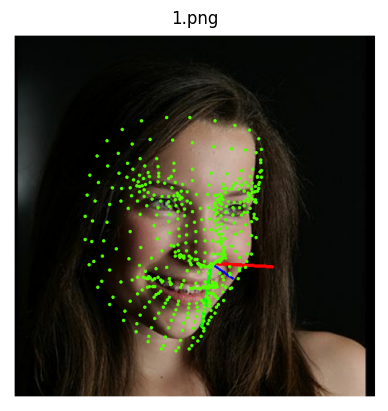

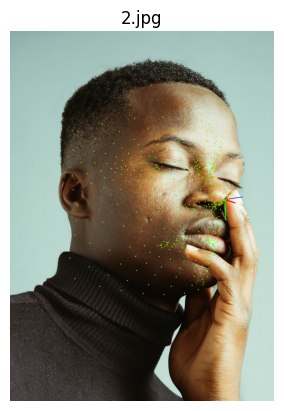

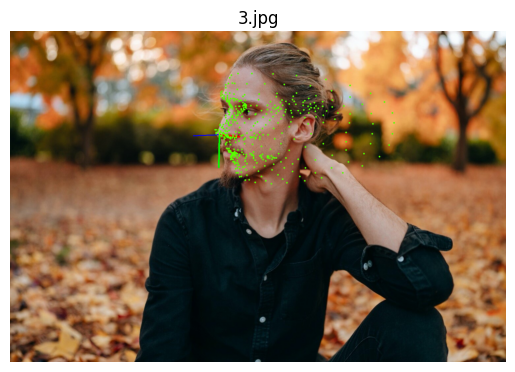

In [16]:

test_images = '../assets/test_images/'

for image_name in os.listdir(test_images):
    img = cv2.imread(test_images + image_name)
    features, nose_x, nose_y = detect_landmarks(img)
    result_img = perform_prediction(pitch_model, yaw_model, roll_model, img)
    
    # Draw the landmarks with a faint color
    for x, y in zip(features[0][:468], features[0][468:]):
        cv2.circle(result_img, (int(x * nose_x[0] + nose_x[0]), int(y * nose_y[0] + nose_y[0])), radius=1, color=(0, 255, 85, 50), thickness=2)
    
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(image_name)
    plt.axis('off')
    plt.show()

### Prediction via `DenseNN`

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


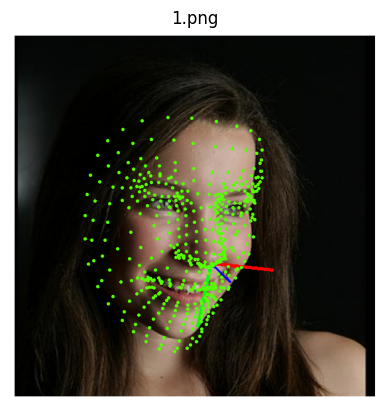

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


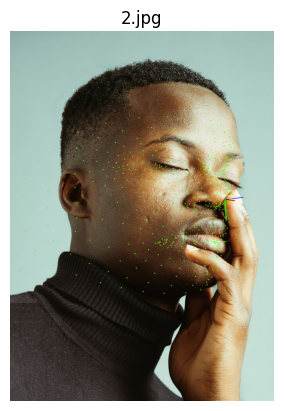

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


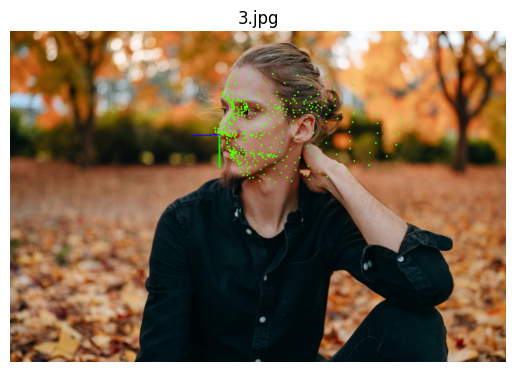

In [18]:
# Test the Dense Neural Network model
for image_name in os.listdir(test_images):
    img = cv2.imread(test_images + image_name)
    result_img = perform_prediction_dense(model_DNN, img)
    
    # Draw the landmarks with a faint color
    features, nose_x, nose_y = detect_landmarks(img)
    for x, y in zip(features[0][:468], features[0][468:]):
        cv2.circle(result_img, (int(x * nose_x[0] + nose_x[0]), int(y * nose_y[0] + nose_y[0])), radius=1, color=(0, 255, 85, 50), thickness=2)
    
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(image_name)
    plt.axis('off')
    plt.show()

# Prediction: Video

In [1]:
test = '../assets/test.mp4' # only one person in the video is allowed

cap = cv2.VideoCapture(test)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, frame_rate, (width, height))

while True:
  try:
    # Read the next frame from the video
    ret, frame = cap.read()
    if not ret:
      break

    # Perform prediction on the frame
    frame = perform_prediction(pitch_model, yaw_model, roll_model, frame)

    # Write the frame to the output video
    out.write(frame)
  except Exception as e:
    print(f"Error: {e}")
    pass

# Release the video capture and output object
cap.release()
out.release()

NameError: name 'cv2' is not defined

# Prediction: Webcam

In [ ]:
cap = cv2.VideoCapture(0)

Selected_model = 'SVR'

# Initialize variables to calculate FPS
prev_frame_time = 0
new_frame_time = 0

while True:
    try:
        # Read the next frame from the video
        ret, frame = cap.read()
        if not ret:
            break

        # Calculate FPS
        new_frame_time = cv2.getTickCount()
        fps = cv2.getTickFrequency() / (new_frame_time - prev_frame_time)
        prev_frame_time = new_frame_time

        if Selected_model == 'SVR':
            frame = perform_prediction(pitch_model, yaw_model, roll_model, frame)
        elif Selected_model == 'DenseNN':
            frame = perform_prediction_dense(model_5, frame)

        # Detect landmarks
        face_module = mp.solutions.face_mesh
        with face_module.FaceMesh(static_image_mode=False, max_num_faces=1) as face_mesh:
            results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    for landmark in face_landmarks.landmark:
                        x = int(landmark.x * frame.shape[1])
                        y = int(landmark.y * frame.shape[0])
                        cv2.circle(frame, (x, y), radius=1, color=(200, 200, 200, 50), thickness=1)

        # Display the FPS on the frame
        cv2.putText(frame, f'FPS: {int(fps)}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Display the frame
        cv2.imshow('Camera', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) == ord('q'):
            break
    except Exception as e:
        print(f"Error: {e}")
        pass

# Release the video capture and close cv2 windows
cap.release()
cv2.destroyAllWindows()

# EVAL: `AngularError`

In [37]:
# Load the normalized features
features = np.load('../data/features.npz')['features']
labels = np.load('../data/labels.npz')['labels']

# Check the shapes of the loaded data
print(f'Labels shape: {labels.shape}')
print(f'Features shape: {features.shape}')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15, random_state=42, shuffle=True)

Labels shape: (1853, 3)
Features shape: (1853, 936)


In [12]:
pitch_model = model_svr[0]
yaw_model = model_svr[1]
roll_model = model_svr[2]

In [34]:
from sklearn.metrics import mean_absolute_error

# Predict the angles using the SVR models
pitch_pred_svr, yaw_pred_svr, roll_pred_svr = model_predict(pitch_model, yaw_model, roll_model, X_test)

# Predict the angles using the Dense Neural Network model
pitch_pred_dnn, yaw_pred_dnn, roll_pred_dnn = model_predict_dense(model_DNN, X_test)


# Calculate the Absolute Angular Error for each angle
aae_pitch_svr = np.mean(np.abs(y_test[:, 0] - pitch_pred_svr))
aae_yaw_svr = np.mean(np.abs(y_test[:, 1] - yaw_pred_svr))
aae_roll_svr = np.mean(np.abs(y_test[:, 2] - roll_pred_svr))

aae_pitch_dnn = np.mean(np.abs(y_test[:, 0] - pitch_pred_dnn))
aae_yaw_dnn = np.mean(np.abs(y_test[:, 1] - yaw_pred_dnn))
aae_roll_dnn = np.mean(np.abs(y_test[:, 2] - roll_pred_dnn))

# Print the results in a tabular format
print(f"{'Model':<15}{'Pitch':<15}{'Yaw':<15}{'Roll':<15}{'Mean':<15}")
print(f"{'SVR Model':<15}{aae_pitch_svr:<15.4f}{aae_yaw_svr:<15.4f}{aae_roll_svr:<15.4f}{np.mean([aae_pitch_svr, aae_yaw_svr, aae_roll_svr]):<15.4f}")
print(f"{'DenseNN Model':<15}{aae_pitch_dnn:<15.4f}{aae_yaw_dnn:<15.4f}{aae_roll_dnn:<15.4f}{np.mean([aae_pitch_dnn, aae_yaw_dnn, aae_roll_dnn]):<15.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Model          Pitch          Yaw            Roll           Mean           
SVR Model      0.0812         0.0589         0.0525         0.0642         
DenseNN Model  0.1026         0.0695         0.0721         0.0814         
